# Extended bullish engulfing - Strategy - Backtesting 

### Import Library

In [15]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

### Load Price Data

In [16]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [17]:
data = dataset.copy()

In [18]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [19]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-10-21 14:10:00,1927.5,1933.0,1918.7,1922.0,16658
2025-10-21 14:15:00,1922.0,1927.5,1919.2,1921.5,8361
2025-10-21 14:20:00,1921.5,1926.0,1902.9,1906.7,16009


In [20]:
def detect_extended_bullish_engulfing(df):
    cond1 = df['Close'].shift(2) < df['Open'].shift(2)  # nến 1 đỏ
    cond2 = df['Close'].shift(1) < df['Open'].shift(1)  # nến 2 đỏ
    cond3 = df['Close'].shift(1) < df['Close'].shift(2)
    cond4 = df['Close'] > df['Open']                    # nến 3 xanh
    cond5 = df['Close'] > df[['Open','Close']].shift(1).max(axis=1)
    cond6 = df['Close'] > df[['Open','Close']].shift(2).max(axis=1)
    df['bullish_engulfing'] = cond2 & cond3 & cond4 & cond5 & cond6
    return df

def detect_downtrend(df, price_col='Close', period=20):
    df = df.copy()
    df['SMA'] = df[price_col].rolling(period).mean()
    df['Downtrend'] = (df[price_col] < df['SMA']) & (df['SMA'].diff() < 0)
    return df

def detect_pullback(df, price_col='Close', lookback=20, drop_pct=0.05):
    df['max_10'] = df["High"].rolling(10).max()
    df['min_3'] = df["Low"].rolling(3).min()
    df['DeepPullback'] = (df['max_10'] - df['Close'] > 2 * (df['Close'] - df['min_3']))
    return df

In [21]:
def cal_signal(df):
    cond1 = df['bullish_engulfing']
    # df["vol_avg"] = df["Volume"].rolling(20).mean()
    # cond2 = df["Volume"] > df["vol_avg"]
    cond2 = df["Volume"] < (df["Volume"].shift(1) + df["Volume"].shift(2))/2
    cond3 = df['Downtrend'].shift(1)
    cond4 = df['DeepPullback']
    df['long_signal'] = cond1 & cond2 & cond3 & cond4
    return df

In [22]:
data = detect_extended_bullish_engulfing(data)
data = detect_downtrend(data)
data = detect_pullback(data)
prepared_data = cal_signal(data)
prepared_data.dropna(inplace=True)

In [29]:
prepared_data[prepared_data.long_signal == True]

,Open,High,Low,Close,Volume,bullish_engulfing,SMA,Downtrend,max_10,min_3,DeepPullback,long_signal
Date,,,,,,,,,,,,
2020-11-27 11:25:00,971.5,972.5,971.4,972.1,1114,True,972.275,False,974.0,971.3,True,True
2021-02-08 11:10:00,1089.9,1095.2,1088.1,1095.0,6830,True,1113.495,True,1117.7,1086.2,True,True
2021-02-26 09:40:00,1160.0,1161.6,1157.4,1161.6,3096,True,1165.970,True,1182.0,1157.4,True,True
2021-03-23 09:25:00,1192.1,1193.4,1192.1,1193.3,2536,True,1197.835,True,1199.8,1190.7,True,True
2021-03-24 09:40:00,1175.2,1176.5,1175.1,1176.1,2244,True,1179.540,True,1184.5,1174.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-18 09:10:00,1631.5,1633.3,1631.5,1632.7,2656,True,1638.115,True,1640.3,1630.8,True,True
2025-09-04 11:15:00,1845.6,1848.3,1844.9,1847.9,4817,True,1854.540,True,1859.0,1843.6,True,True
2025-09-19 10:15:00,1845.4,1846.8,1844.3,1846.0,2406,True,1850.365,True,1852.3,1843.8,True,True


In [23]:
class MainStrategy(Strategy):
    risk = 4
    RR = 2
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.long_signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if signal == True:
            buy_price = close_price
            sl = buy_price - self.risk
            tp = buy_price + self.RR * self.risk
            self.buy(size=1, sl=sl, tp=tp)
            # self.buy(size=1, sl=sl, tp=tp, limit=buy_price)

In [24]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [25]:
stats

Start                     2020-11-02 10:35:00
End                       2025-10-21 14:45:00
Duration                   1814 days 04:10:00
Exposure Time [%]                     2.96805
Equity Final [$]                   1385.53885
Equity Peak [$]                       1507.61
Commissions [$]                      93.56115
Return [%]                           -7.63074
Buy & Hold Return [%]               111.27418
Return (Ann.) [%]                    -1.60018
Volatility (Ann.) [%]                 1.84397
CAGR [%]                             -1.09653
Sharpe Ratio                         -0.86779
Sortino Ratio                        -1.15506
Calmar Ratio                         -0.17542
Alpha [%]                            -8.70837
Beta                                  0.00968
Max. Drawdown [%]                    -9.12209
Avg. Drawdown [%]                    -1.41092
Max. Drawdown Duration     1698 days 04:25:00
Avg. Drawdown Duration      253 days 00:42:00
# Trades                          

In [26]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,Commission,ReturnPct,EntryTime,ExitTime,Duration,Tag
0,1,978,988,972.1,968.1,968.1,980.1,-4.58206,0.58206,-0.004714,2020-11-27 11:30:00,2020-11-27 13:45:00,0 days 02:15:00,None
1,1,3522,3522,1095.2,1103.0,1091.0,1103.0,7.14054,0.65946,0.006520,2021-02-08 11:15:00,2021-02-08 11:15:00,0 days 00:00:00,None
2,1,3963,3985,1161.6,1154.1,NaN,1169.6,-8.19471,0.69471,-0.007055,2021-02-26 09:45:00,2021-02-26 13:00:00,0 days 03:15:00,None
3,1,4820,4834,1193.5,1189.3,1189.3,1201.3,-4.91484,0.71484,-0.004118,2021-03-23 09:30:00,2021-03-23 10:40:00,0 days 01:10:00,None
4,1,4874,4889,1176.2,1172.1,1172.1,1184.1,-4.80449,0.70449,-0.004085,2021-03-24 09:45:00,2021-03-24 11:00:00,0 days 01:15:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1,56704,56706,1297.5,1293.5,1293.5,1305.5,-4.77730,0.77730,-0.003682,2025-04-21 09:15:00,2025-04-21 09:25:00,0 days 00:10:00,None
125,1,56724,56729,1291.5,1287.5,1287.5,1299.5,-4.77370,0.77370,-0.003696,2025-04-21 10:55:00,2025-04-21 11:20:00,0 days 00:25:00,None
126,1,56791,56792,1236.6,1244.2,1232.2,1244.2,6.85576,0.74424,0.005544,2025-04-22 13:40:00,2025-04-22 13:45:00,0 days 00:05:00,None
127,1,56929,56954,1308.0,1310.3,1304.0,1316.0,1.51451,0.78549,0.001158,2025-04-25 11:00:00,2025-04-25 14:30:00,0 days 03:30:00,None


In [27]:
# bt.plot()

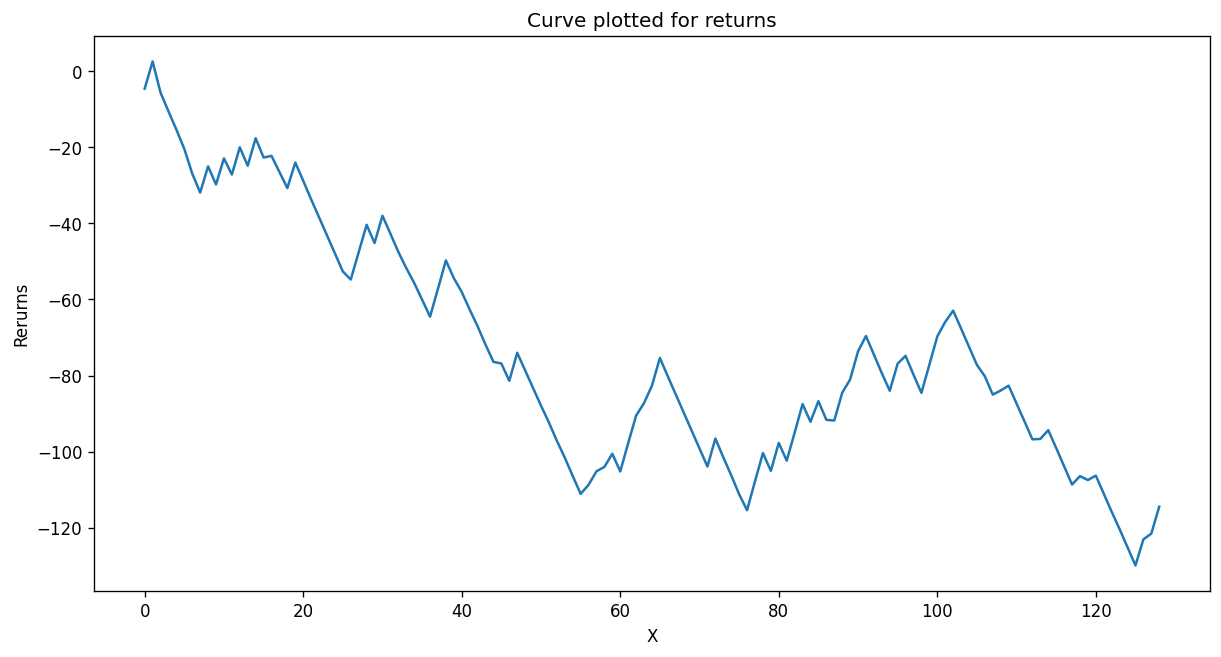

In [28]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()